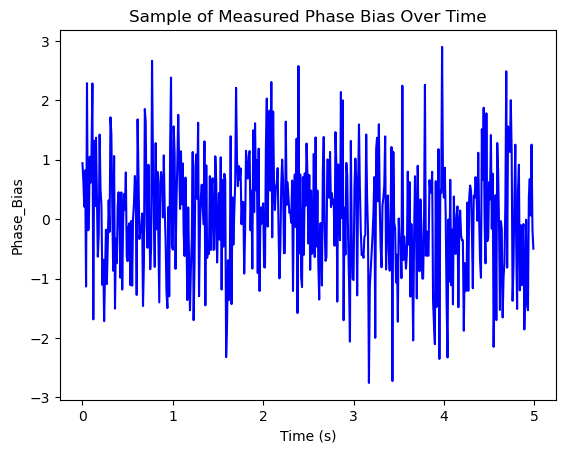

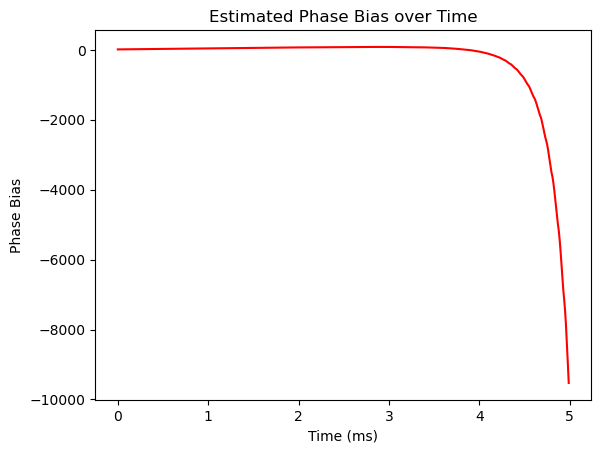

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

Time_Step = 0.01  
Time = np.arange(0, 5, Time_Step)

Interrogation_Time = 20e-3 
Temperature = 4e-6 
Wavelength_of_Laser = 500e-9 
Measurement_Offset = 1 
Standard_Deviation_Offset = 3e-3
Contrast = 0.2  
Standard_Deviation_Contrast = 4.5e-3  
Detection_Noise = np.random.randn() * 0.3  
Laser_Phase = 0.1  
Inertial_Phase = 0.25 
Phase_Bias = 12 
Standard_Deviation_Bias = 56e-3  
Change_Phase_Bias = 30 
Standard_Deviation_Bias_Change = 0.1 

Scaling_Factor = (4 * np.pi / Wavelength_of_Laser)*(Interrogation_Time**2)  
Accellerometer_Noise = 0.5
State_Vector = np.array([Phase_Bias, Change_Phase_Bias, Measurement_Offset, Contrast])

Evolution_Matrix = np.array([[1, Time_Step, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
Covariance_Matrix = 10e-3 * np.array([[0, 0, 0, 0], [0, (Standard_Deviation_Bias_Change**2), 0, 0], [0, 0, (Standard_Deviation_Offset**2), 0], [0, 0, 0, (Standard_Deviation_Contrast**2)]])
Random_Evolutions = Time_Step * np.array([Standard_Deviation_Bias* np.random.randn(), Standard_Deviation_Bias_Change*np.random.randn(), Standard_Deviation_Offset*np.random.randn(), Standard_Deviation_Contrast*np.random.randn()])

Error_Covariance = np.zeros((4, 4))
Measurement_Covariance = 0.01 * np.eye(4)

Measured_Phase_Bias = 0.2*np.sin(Time) + np.random.randn(len(Time))

plt.figure()
plt.plot(Time, Measured_Phase_Bias, 'b')
plt.title("Sample of Measured Phase Bias Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Phase_Bias")
plt.show()

Measured_Change_Phase_Bias = np.abs(40*np.sin(4*np.pi*Time) + 30*np.sin(7*np.pi*Time)) + Random_Evolutions[1]
Measured_Offset = np.abs(np.sin(3*np.pi*Time)) + Random_Evolutions[2]
Measured_Contrast = (0.2 + np.abs(0.2*np.sin(15*np.pi*Time))) + Random_Evolutions[3]

Kalman_Gain = np.zeros((4))
Estimated_States = np.zeros((4, len(Time)))

def Kalman_Prediction(Offset, Contrast, Phase_Bias, Laser_Phase, Inertial_Phase, Detection_Noise, Accellerometer_Noise):
    
    True_Phase = Inertial_Phase + Phase_Bias + Accellerometer_Noise
    
    Measurement_Prediction = Offset - (Contrast/ 2)*np.cos(Laser_Phase + Inertial_Phase) + Detection_Noise
    Kalman_Jacobian = np.array([(Contrast/ 2) * np.sin(True_Phase - Phase_Bias), 0, 1, (-1 / 2) * np.cos(True_Phase - Phase_Bias)])
    
    return Measurement_Prediction, Kalman_Jacobian

for i in range(len(Time)):
    
    Predicted_State_Estimate = Evolution_Matrix @ State_Vector + Random_Evolutions
    Predicted_Error_Covariance = Evolution_Matrix @ Error_Covariance @ Evolution_Matrix.T + Covariance_Matrix
    
    Current_Prediction, Current_Jacobian = Kalman_Prediction(Measured_Offset[i], Measured_Contrast[i], Measured_Phase_Bias[i], Laser_Phase, Inertial_Phase, Detection_Noise, 0)
    Previous_Prediction, Previous_Jacobian = Kalman_Prediction(Predicted_State_Estimate[2], Predicted_State_Estimate[3], Predicted_State_Estimate[0], Laser_Phase, Inertial_Phase, Detection_Noise, 0)
    
    Kalman_Innovation = Current_Prediction - Previous_Prediction

    State_Vector = Predicted_State_Estimate + Kalman_Gain.T * Kalman_Innovation
    
    Error_Covariance = (np.eye(4) - Kalman_Gain @ Current_Jacobian.T) @ Predicted_Error_Covariance
    
    """
    S = Current_Jacobian @ Error_Covariance @ Current_Jacobian.T + Measurement_Covariance
    cho_factor = scipy.linalg.cho_factor(S)
    Kalman_Gain = scipy.linalg.cho_solve(cho_factor, Current_Jacobian @ Error_Covariance).T

    Kalman_Gain = Error_Covariance @ Current_Jacobian.T @ np.linalg.pinv(Current_Jacobian @ Error_Covariance @ Current_Jacobian.T + Measurement_Covariance)
    """
    
    Kalman_Gain = Error_Covariance @ Current_Jacobian.T @ np.linalg.inv(Current_Jacobian @ Error_Covariance @ Current_Jacobian.T + Measurement_Covariance)
    

    Estimated_States[:,i] = State_Vector
    
plt.figure()
plt.plot(Time, Estimated_States[0,:], 'r')
plt.title("Estimated Phase Bias over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Phase Bias")
plt.show()
